In [18]:
#Download dependencies before proceeding

import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from arboreto.algo import grnboost2
import os
import umap

sns.set(rc={'figure.figsize':(12,8)})
sns.set(style='whitegrid')

In [2]:
#Read in time-series RNA-seq data
data_df = []
names = []

for name in os.listdir('/Users/Jake/MachineLearningProstate/data/timeseries/'):
    data_df.append(pd.read_csv(f'/Users/Jake/MachineLearningProstate/data/timeseries/{name}'))
    names.append(name)
tf_df = pd.read_csv('Homo_sapiens_TF.csv')
#List of TFs
tfs = set(tf_df['Symbol'].tolist())
#Create transcription factor DF 
#Training can occur on just TFs or with all genes, depending on computational resources.
onlytfs_df = []
for i in data_df:
    x = i[i['Gene'].isin(tfs)]
    x = x.set_index('Gene')
    onlytfs_df.append(x)


In [61]:
# Merge all data into one df for UMAP
all_data = data_df[0]
for i in range(1, len(data_df)):
    all_data = pd.merge(all_data, data_df[i], on = ['Gene'], how='inner')

# Remove rows containing genes with na values--should be none, but just in case
all_data = all_data.dropna()

# Take transpose of dataframe
all_data = all_data.T

# Make gene names into column names and remove from matrix
all_data.columns = all_data.iloc[0]
all_data = all_data.drop(['Gene'])

# Add factors to dataframe
rows = list(all_data.index)
rowtypes = [x.split('_')[1] if (len(x.split('_')) > 2) else 'timeseries' for x in rows]
doses = [x.split('_')[2] if (len(x.split('_')) > 2) else x.split('_')[1] for x in rows]
all_data_umap = all_data.copy()
all_data_umap.insert(0, 'Sample Type', rowtypes, True)
all_data_umap.insert(1, 'Doses', doses, True)


print(all_data.head)
print(all_data_umap.head)

<bound method NDFrame.head of Gene                       LBH       HPGD     CHRDL2       KRT75    CACNA1A  \
LNCaP_Clone07_04uM    0.833386        0.0   0.833386    1.666772        0.0   
LNCaP_Clone07_16uM         0.0   3.364998   3.364998    3.364998        0.0   
LNCaP_Clone07_50uM   14.909345   29.81869  79.516507  120.517207   1.242445   
LNCaP_Clone04_04uM    0.742849        0.0        0.0    2.228546        0.0   
LNCaP_Clone04_16uM    6.024117        0.0    3.61447    6.024117        0.0   
LNCaP_Clone04_50uM  119.985675  21.570458  25.614919    14.82969        0.0   
LNCaP_Clone10_04uM         0.0        0.0        0.0         0.0        0.0   
LNCaP_Clone10_16uM         0.0        0.0   1.988285    4.970713   0.994143   
LNCaP_Clone10_50uM   82.704033   4.531728  21.525707   60.045394        0.0   
LNCaP_04uM            1.834881        0.0        0.0    4.587203        0.0   
LNCaP_08uM            2.561779        0.0        0.0    2.561779        0.0   
LNCaP_16uM            

Get UMAP working here

In [63]:
#Set up UMAP; ensemble it with 100 iterations
niter = 200
embedding = np.zeros((16, 2))

for i in range(niter):
    reducer = umap.UMAP()
    embedding += reducer.fit_transform(all_data)
embedding = np.divide(embedding, niter * np.ones(embedding.shape))

Text(0.5, 1.0, 'UMAP plot of each expression set')

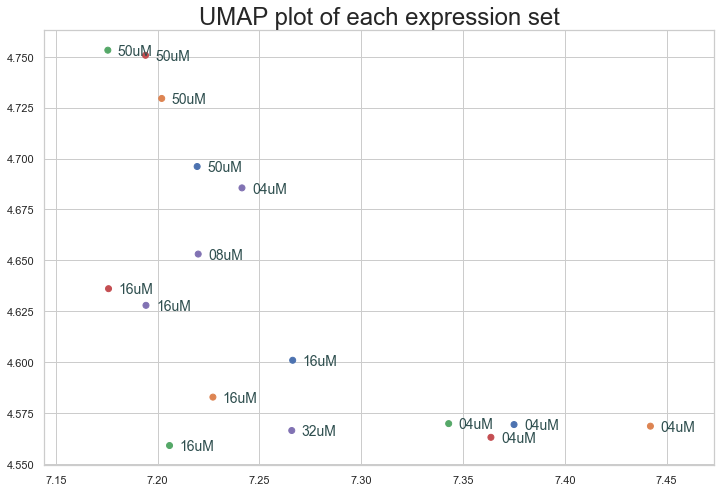

In [65]:
#Make scatter plot of UMAP

fig, ax = plt.subplots()

colors = colors = ['red','green','blue','purple', 'orange']
palette = [sns.color_palette()[x] for x in all_data_umap['Sample Type'].map({"Clone03":0, "Clone04":1, "Clone07":2, 'Clone10': 3, 'timeseries': 4})]

ax.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=palette)
plt.gca().set_aspect('equal', 'datalim')

for i, txt in enumerate(doses):
    ax.annotate(txt, (embedding[i, 0], embedding[i, 1]), xytext=(10,-5), textcoords='offset points',
                family='sans-serif', fontsize=14, color='darkslategrey')

plt.title('UMAP plot of each expression set', fontsize=24)

In [7]:
#Train network using GRNBoost2
network = []
ofile = []
for i in range(len(onlytfs_df)):
    network.append(grnboost2(expression_data=onlytfs_df[i].T))
    print(f"Finished traing {names[i]}")
    #Network file   
    ofile.append(f'trained_network_{names[i]}.csv')
    network[i].to_csv(ofile[i])
    print("Saved network file!")

'WARNING: infer_data failed for target ZNF33B' Retry (1/10). Failure caused by AssertionError().
'WARNING: infer_data failed for target ZNF33B' Retry (2/10). Failure caused by AssertionError().
'WARNING: infer_data failed for target ZNF33B' Retry (3/10). Failure caused by AssertionError().
'WARNING: infer_data failed for target ZNF33B' Retry (4/10). Failure caused by AssertionError().
'WARNING: infer_data failed for target ZNF33B' Retry (5/10). Failure caused by AssertionError().
'WARNING: infer_data failed for target ZNF33B' Retry (6/10). Failure caused by AssertionError().
'WARNING: infer_data failed for target ZNF33B' Retry (7/10). Failure caused by AssertionError().
'WARNING: infer_data failed for target ZNF33B' Retry (8/10). Failure caused by AssertionError().
'WARNING: infer_data failed for target ZNF33B' Retry (9/10). Failure caused by AssertionError().
'WARNING: infer_data failed for target ZNF33B' Retry (10/10). Failure caused by AssertionError().
'WARNING: infer_data failed f

Finished traing LNCaP_Clone07.csv
Saved network file!


'WARNING: infer_data failed for target ZNF33B' Retry (1/10). Failure caused by AssertionError().
'WARNING: infer_data failed for target ZNF33B' Retry (2/10). Failure caused by AssertionError().
'WARNING: infer_data failed for target ZNF33B' Retry (3/10). Failure caused by AssertionError().
'WARNING: infer_data failed for target ZNF33B' Retry (4/10). Failure caused by AssertionError().
'WARNING: infer_data failed for target ZNF33B' Retry (5/10). Failure caused by AssertionError().
'WARNING: infer_data failed for target ZNF33B' Retry (6/10). Failure caused by AssertionError().
'WARNING: infer_data failed for target ZNF33B' Retry (7/10). Failure caused by AssertionError().
'WARNING: infer_data failed for target ZNF33B' Retry (8/10). Failure caused by AssertionError().
'WARNING: infer_data failed for target ZNF33B' Retry (9/10). Failure caused by AssertionError().
'WARNING: infer_data failed for target ZNF33B' Retry (10/10). Failure caused by AssertionError().
'WARNING: infer_data failed f

Finished traing LNCaP_Clone04.csv
Saved network file!


'WARNING: infer_data failed for target ZNF33B' Retry (1/10). Failure caused by AssertionError().
'WARNING: infer_data failed for target ZNF33B' Retry (2/10). Failure caused by AssertionError().
'WARNING: infer_data failed for target ZNF33B' Retry (3/10). Failure caused by AssertionError().
'WARNING: infer_data failed for target ZNF33B' Retry (4/10). Failure caused by AssertionError().
'WARNING: infer_data failed for target ZNF33B' Retry (5/10). Failure caused by AssertionError().
'WARNING: infer_data failed for target ZNF33B' Retry (6/10). Failure caused by AssertionError().
'WARNING: infer_data failed for target ZNF33B' Retry (7/10). Failure caused by AssertionError().
'WARNING: infer_data failed for target ZNF33B' Retry (8/10). Failure caused by AssertionError().
'WARNING: infer_data failed for target ZNF33B' Retry (9/10). Failure caused by AssertionError().
'WARNING: infer_data failed for target ZNF33B' Retry (10/10). Failure caused by AssertionError().
'WARNING: infer_data failed f

Finished traing LNCaP_Clone10.csv
Saved network file!


In [ ]:
#View Network
network.clear()
for i in range(len(ofile)):
    network.append(pd.read_csv(f'/Users/Jake/MachineLearningProstate/STAMPScreen/grn_centrality/{ofile[i]}'))

/Users/Jake/miniconda3/envs/ml/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/Jake/miniconda3/envs/ml/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/Jake/miniconda3/envs/ml/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function w

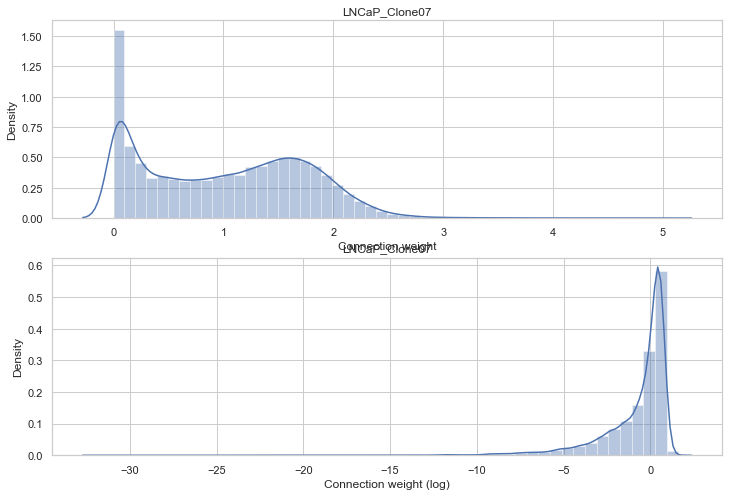

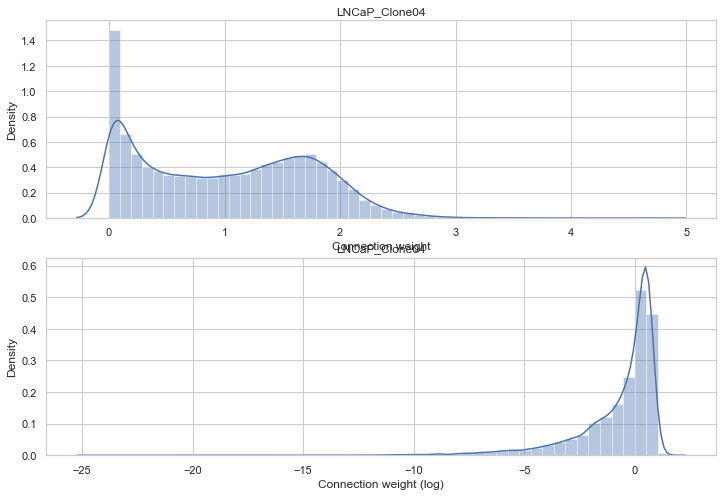

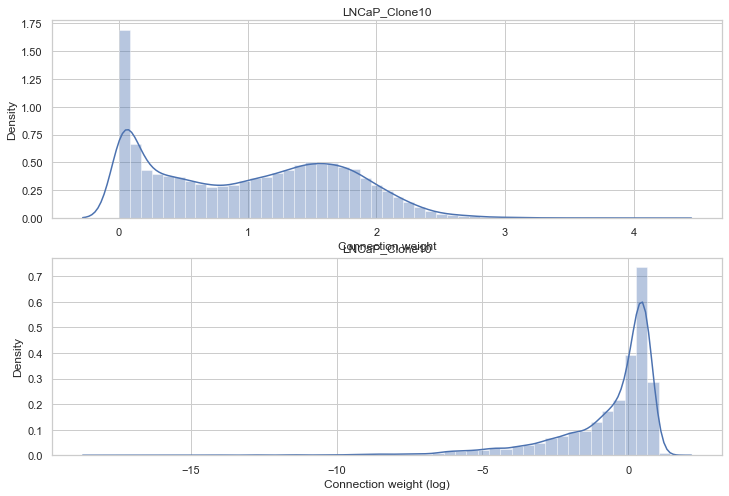

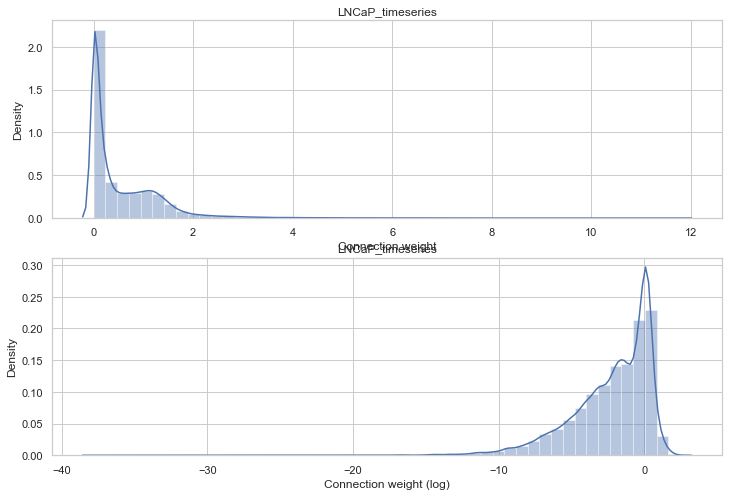

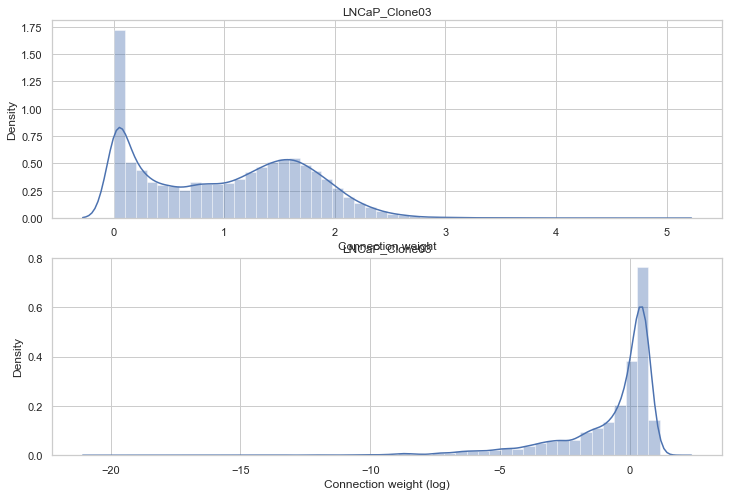

In [ ]:
#Visualize edge weight distribution
for i in range(len(network)):
    f, axes = plt.subplots(2, 1)

    sns.distplot(a=network[i]['importance'], norm_hist=True, ax=axes[0]).set(title= f'{names[i][0:len(names[i])-4]}')
    sns.distplot(a=network[i]['importance'].apply(np.log), norm_hist=True, ax=axes[1]).set(title= f'{names[i][0:len(names[i])-4]}')

    axes[0].set_xlabel('Connection weight')
    axes[1].set_xlabel('Connection weight (log)')

In [ ]:
#Create graph
G = [] 
for i in range(len(network)):
    G.append(nx.from_pandas_edgelist(df=network[i], source='TF', target='target', edge_attr='importance'))
    print('Loaded {:,} genes with {:,} edges.'.format(len(G[i].nodes), len(G[i].edges)))

Loaded 1,189 genes with 29,077 edges.
Loaded 1,189 genes with 29,089 edges.
Loaded 1,188 genes with 29,098 edges.
Loaded 1,189 genes with 109,847 edges.
Loaded 1,188 genes with 29,167 edges.


In [ ]:
#Prune graph

cutoff = 1

print('Removing all edges with weight < {}...\n'.format(cutoff))

for i in range(len(G)):
    bad_edges = [(s,t,w) for (s,t,w) in G[i].edges.data('importance') if w < cutoff]
    G[i].remove_edges_from(bad_edges)
    print('Graph now has {:,} genes and {:,} edges.'.format(len(G[i].nodes), len(G[i].edges)))

Removing all edges with weight < 1...

Graph now has 1,189 genes and 14,836 edges.
Graph now has 1,189 genes and 14,619 edges.
Graph now has 1,188 genes and 14,925 edges.
Graph now has 1,189 genes and 24,186 edges.
Graph now has 1,188 genes and 15,192 edges.


In [ ]:
# Run PageRank
prdf = []
for i in range(len(G)):
    pr = nx.pagerank(G[i], alpha=0.85, max_iter=50, weight='importance')
    #Create dataframe for PageRank values
    prdf.append(pd.DataFrame(pd.Series(pr)).reset_index())
    prdf[i].columns = ['Gene', 'PageRank']
    print("Finished")

Finished
Finished
Finished
Finished
Finished


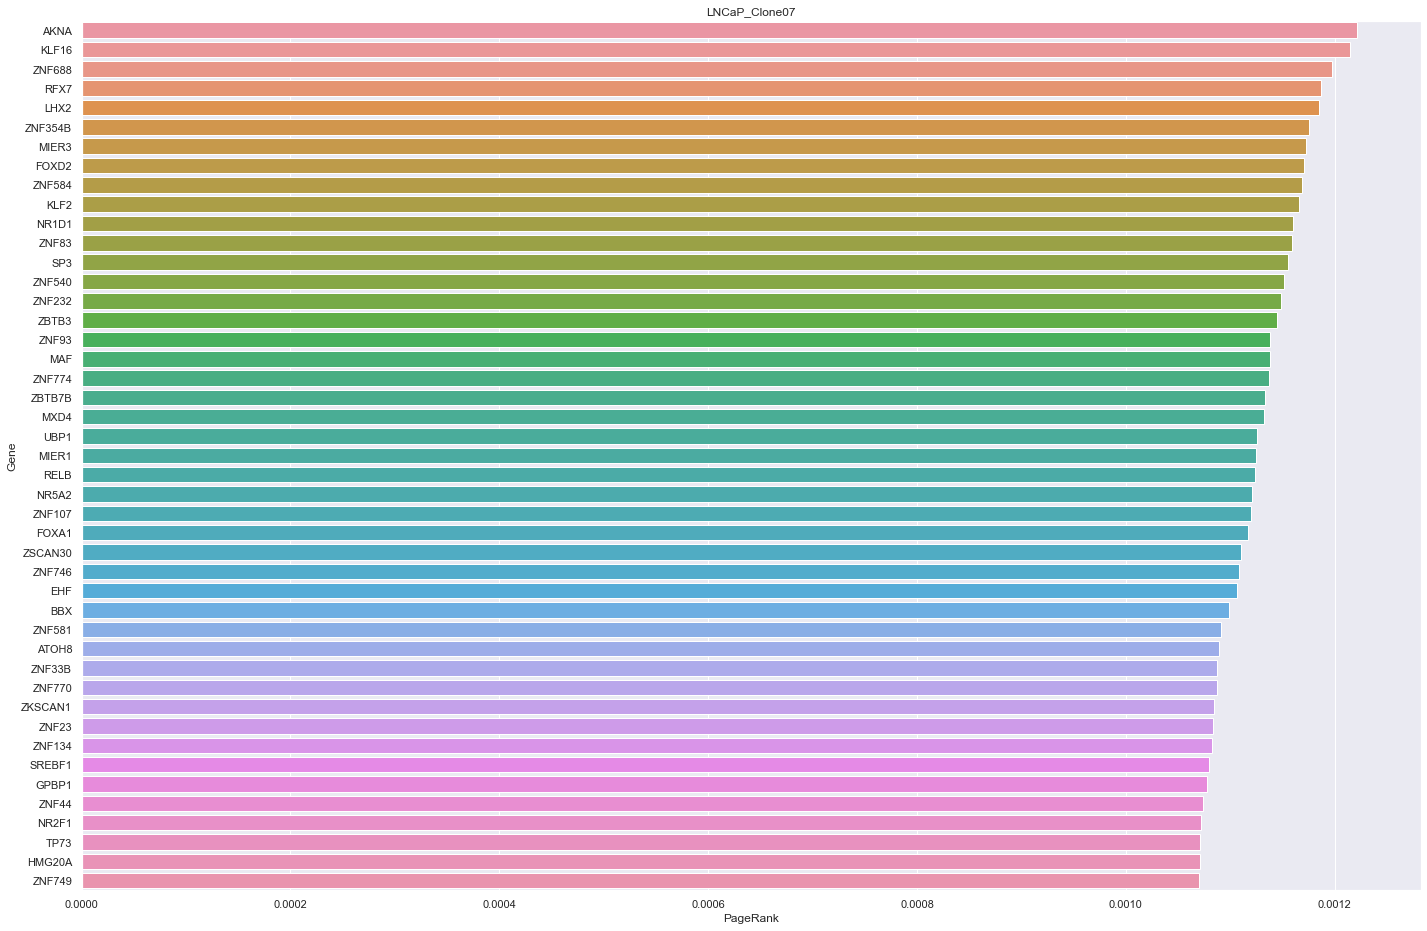

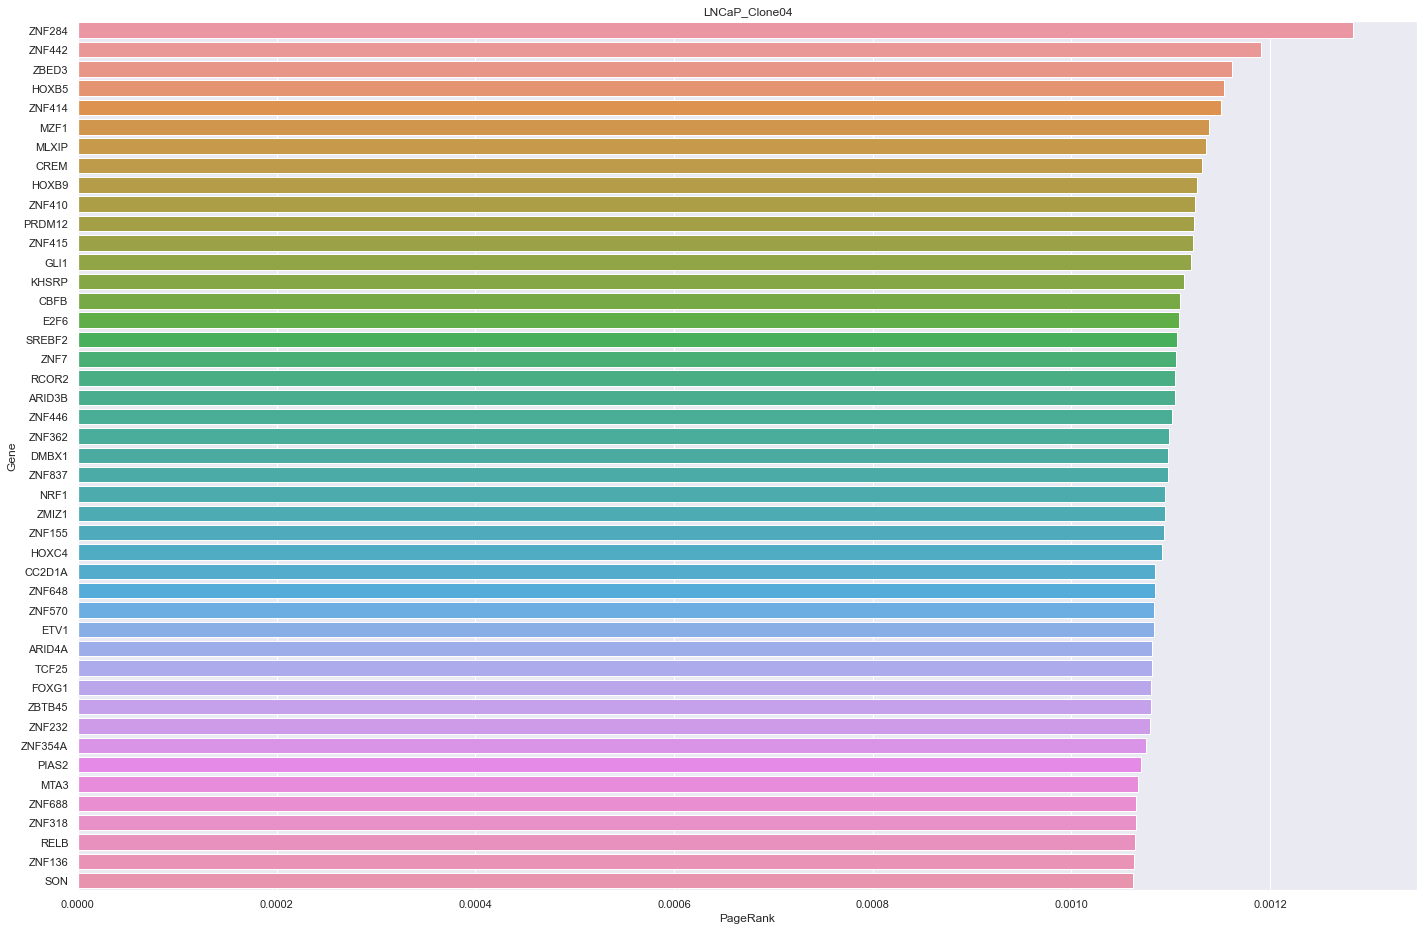

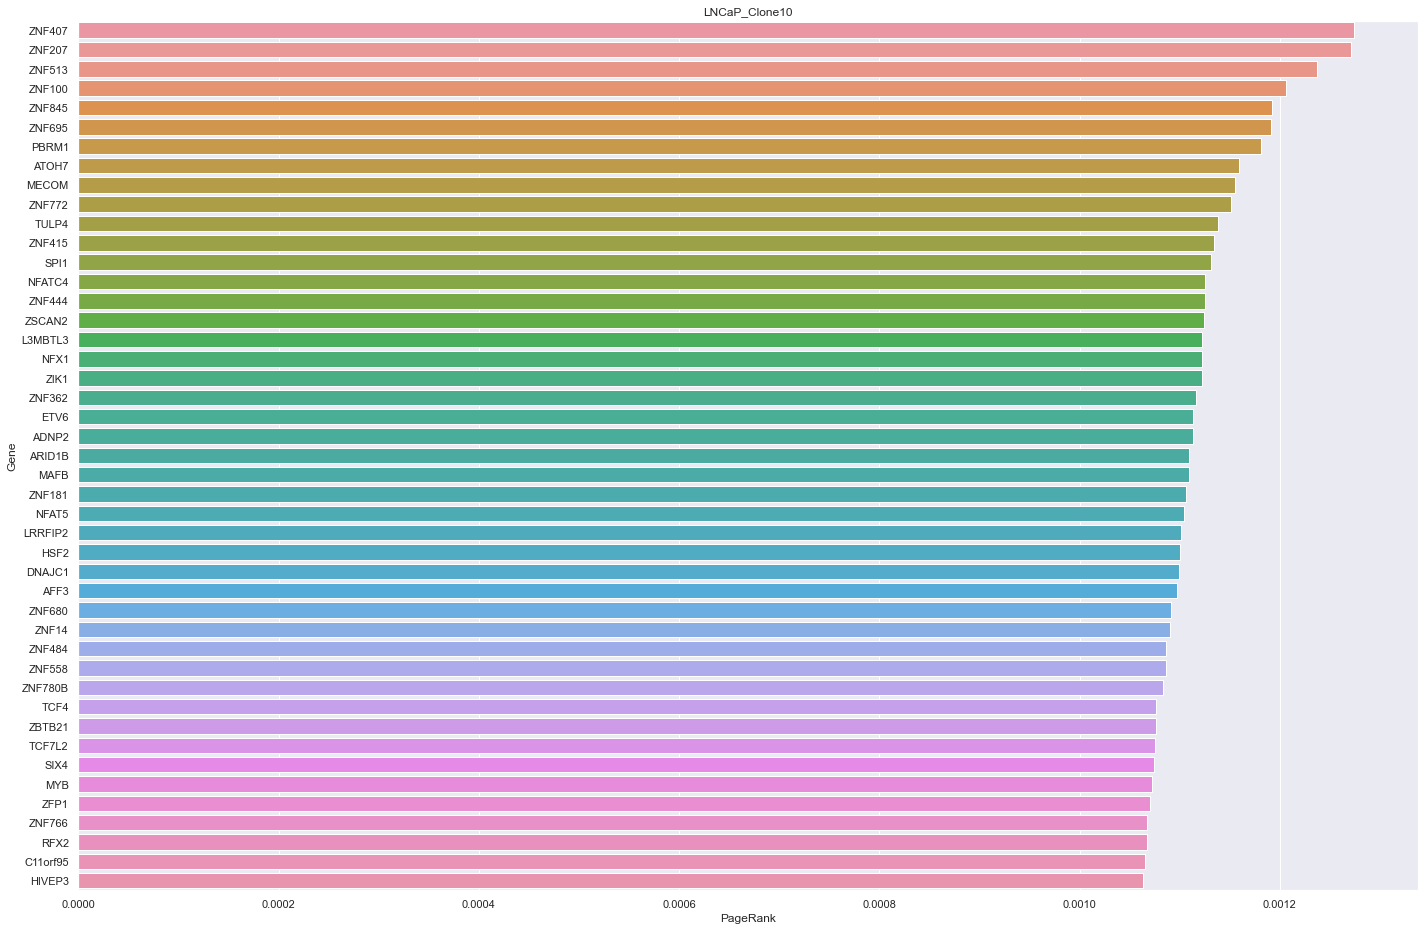

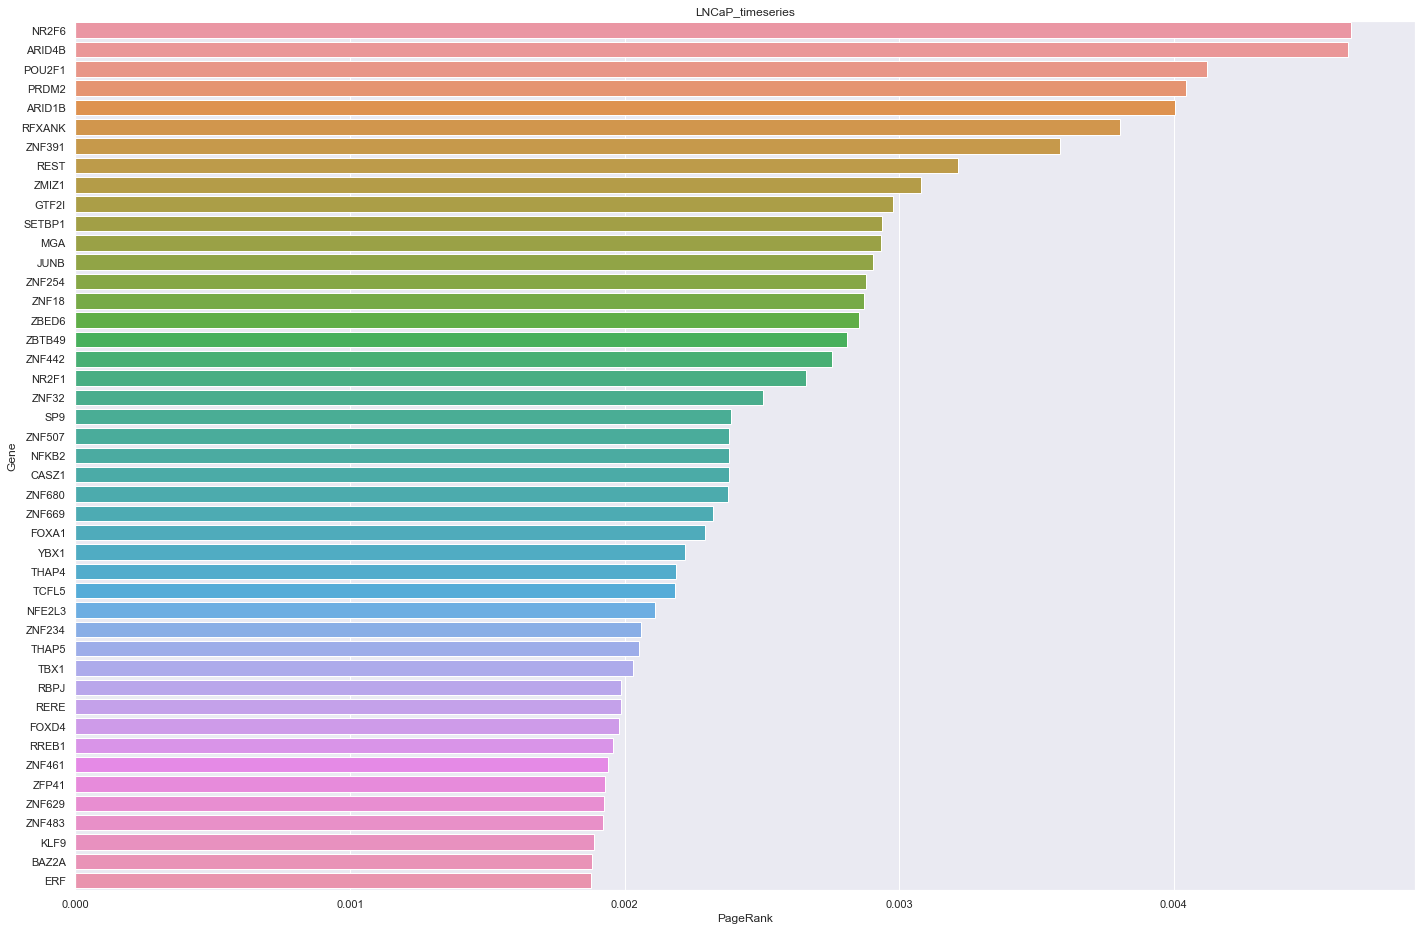

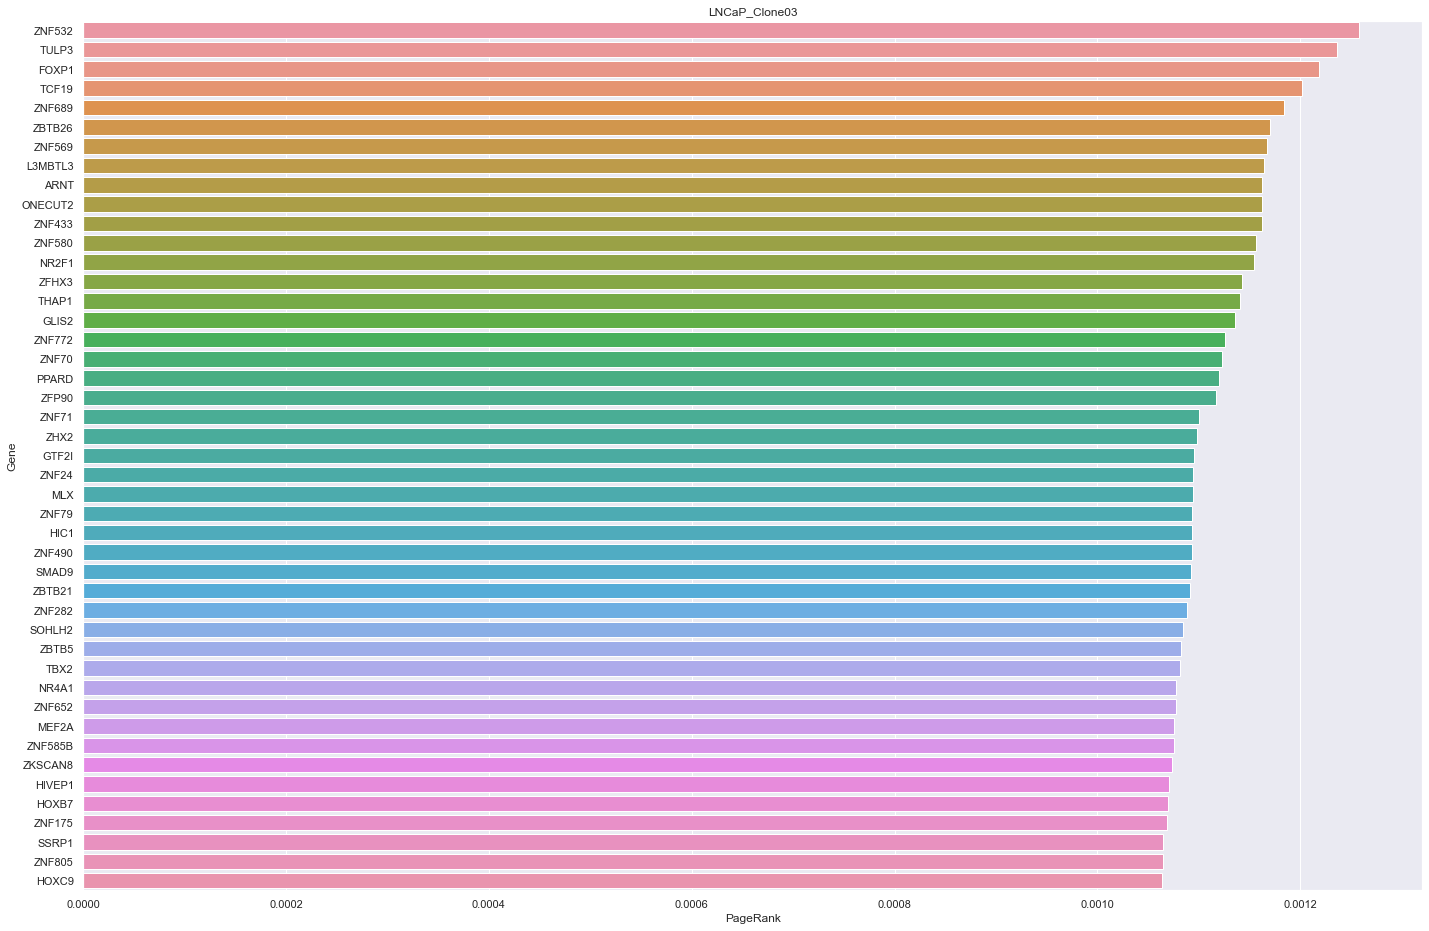

In [ ]:
#View top TFs
for i in range(len(prdf)):
    sns.set(rc={'figure.figsize':(24,16)})
    sns.barplot(
        data=prdf[i].sort_values('PageRank', ascending=False).head(45), 
        x='PageRank', 
        y='Gene'
    ).set(title=f'{names[i][0:len(names[i])-4]}')
    data=prdf[i].sort_values('PageRank', ascending=False)
    #Save ranked TFs
    data.to_csv(f'{names[i][0:len(names[i])-4]}pageranked_tfs.csv')
    plt.show()

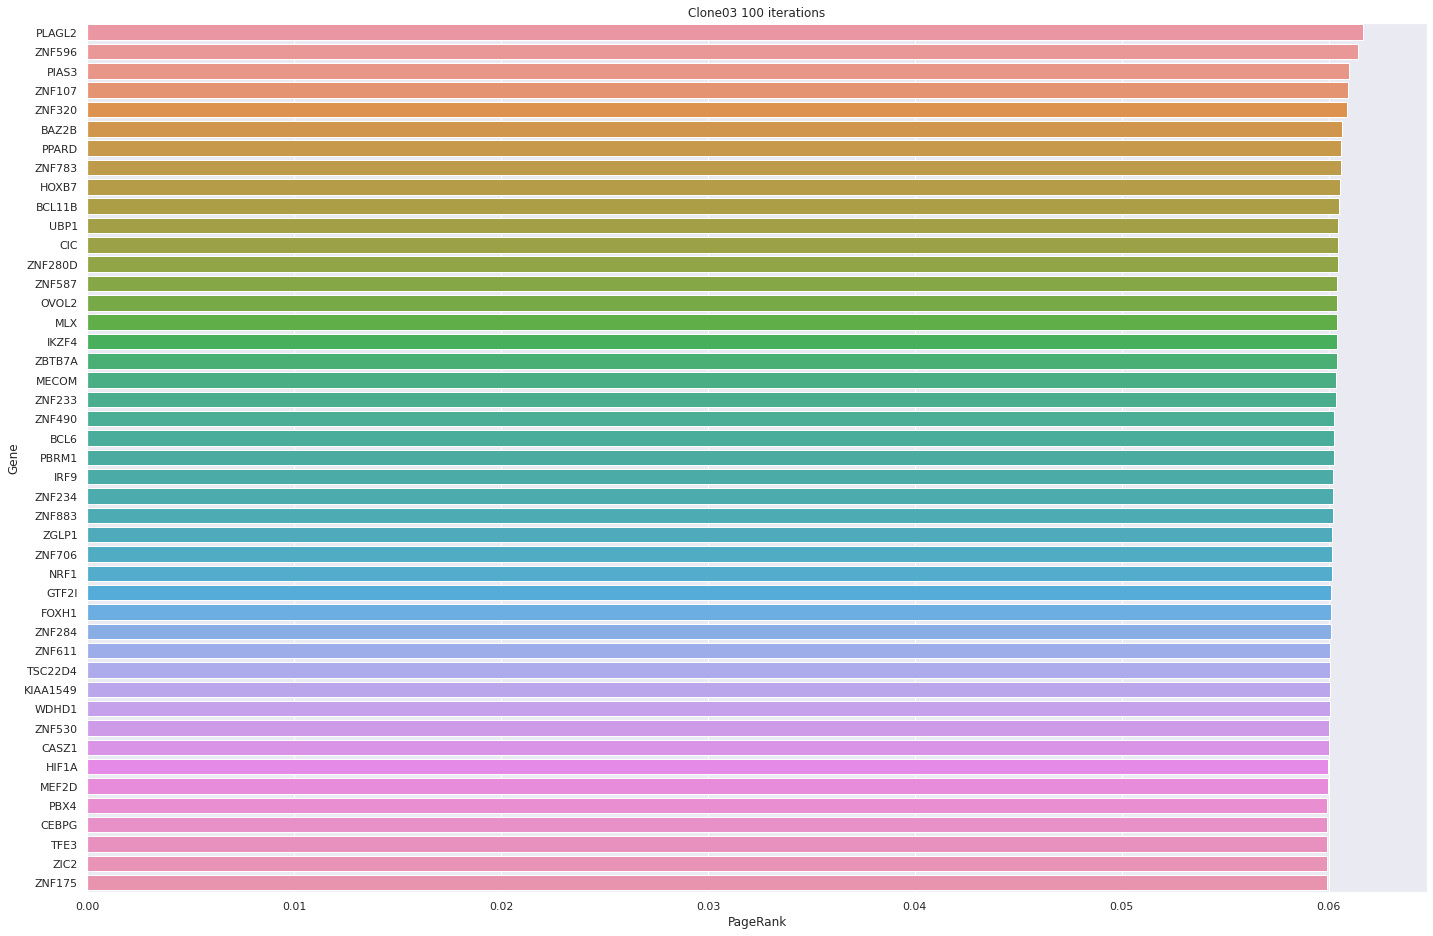

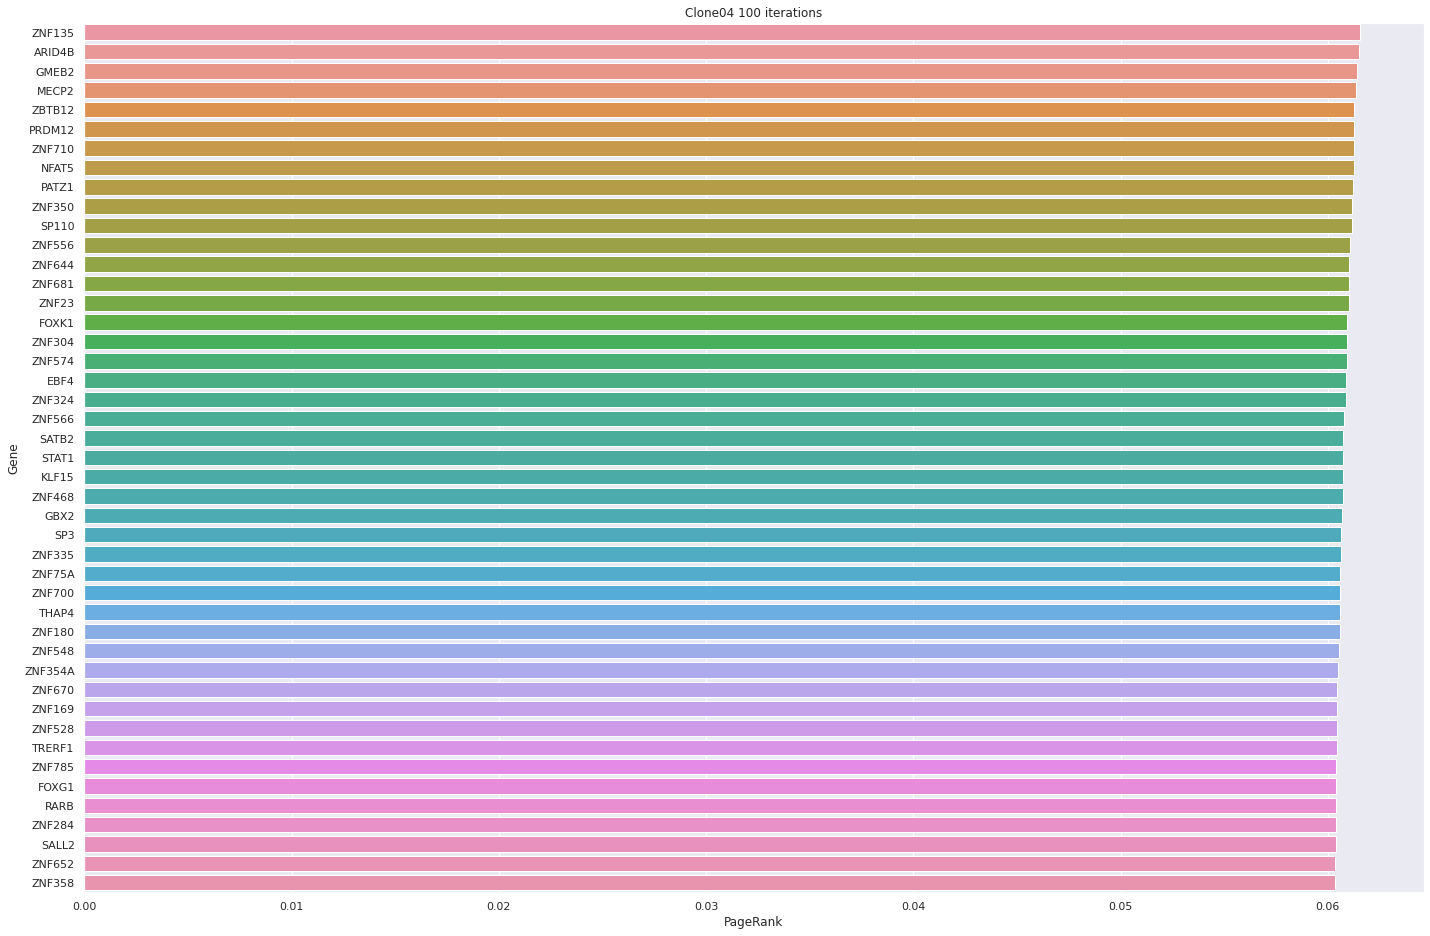

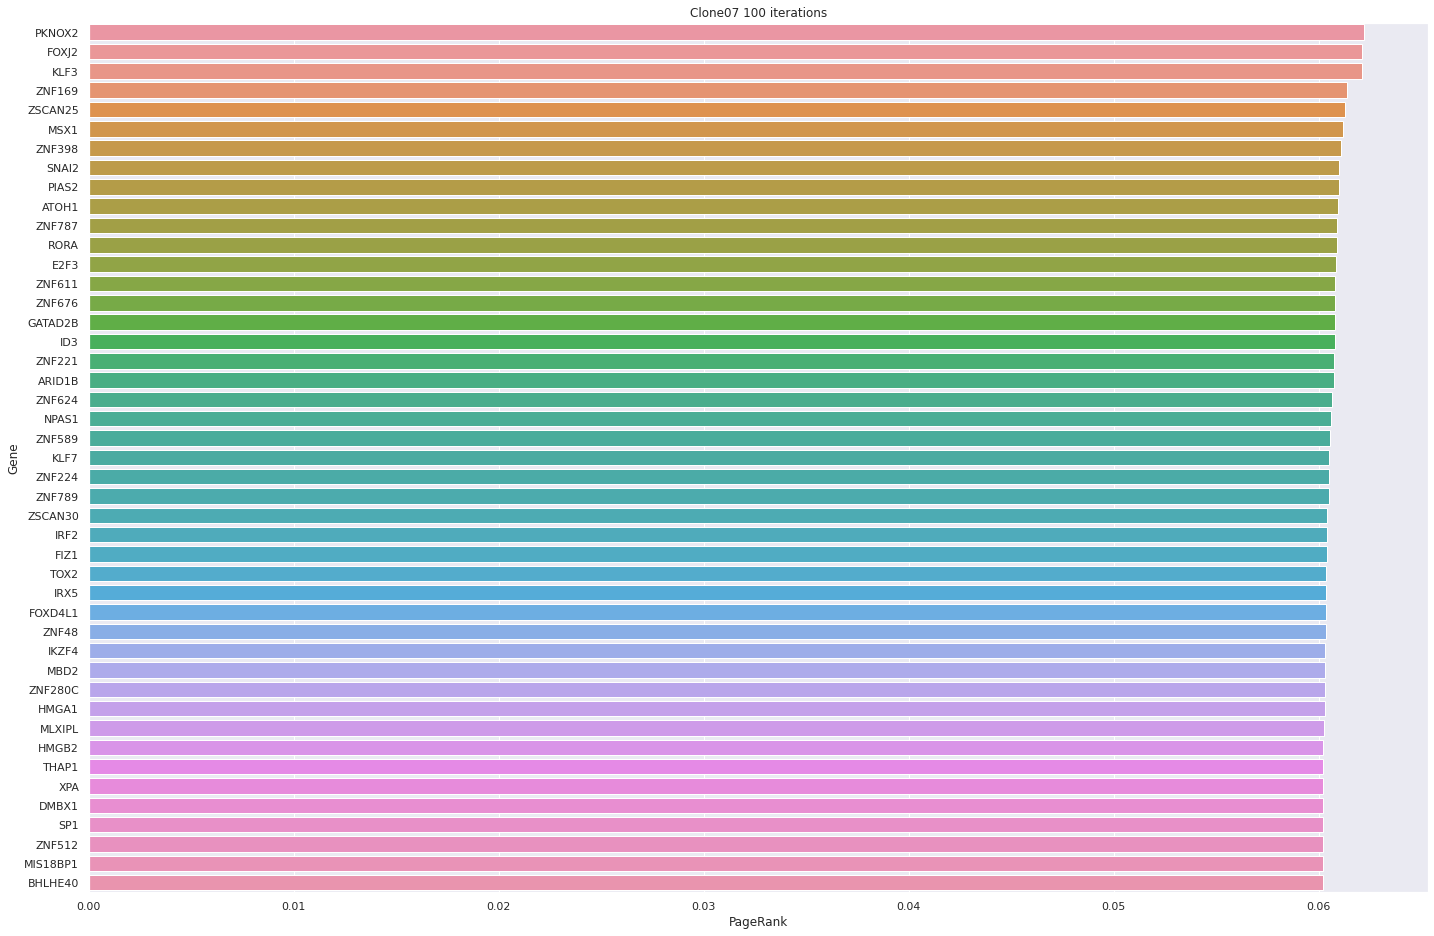

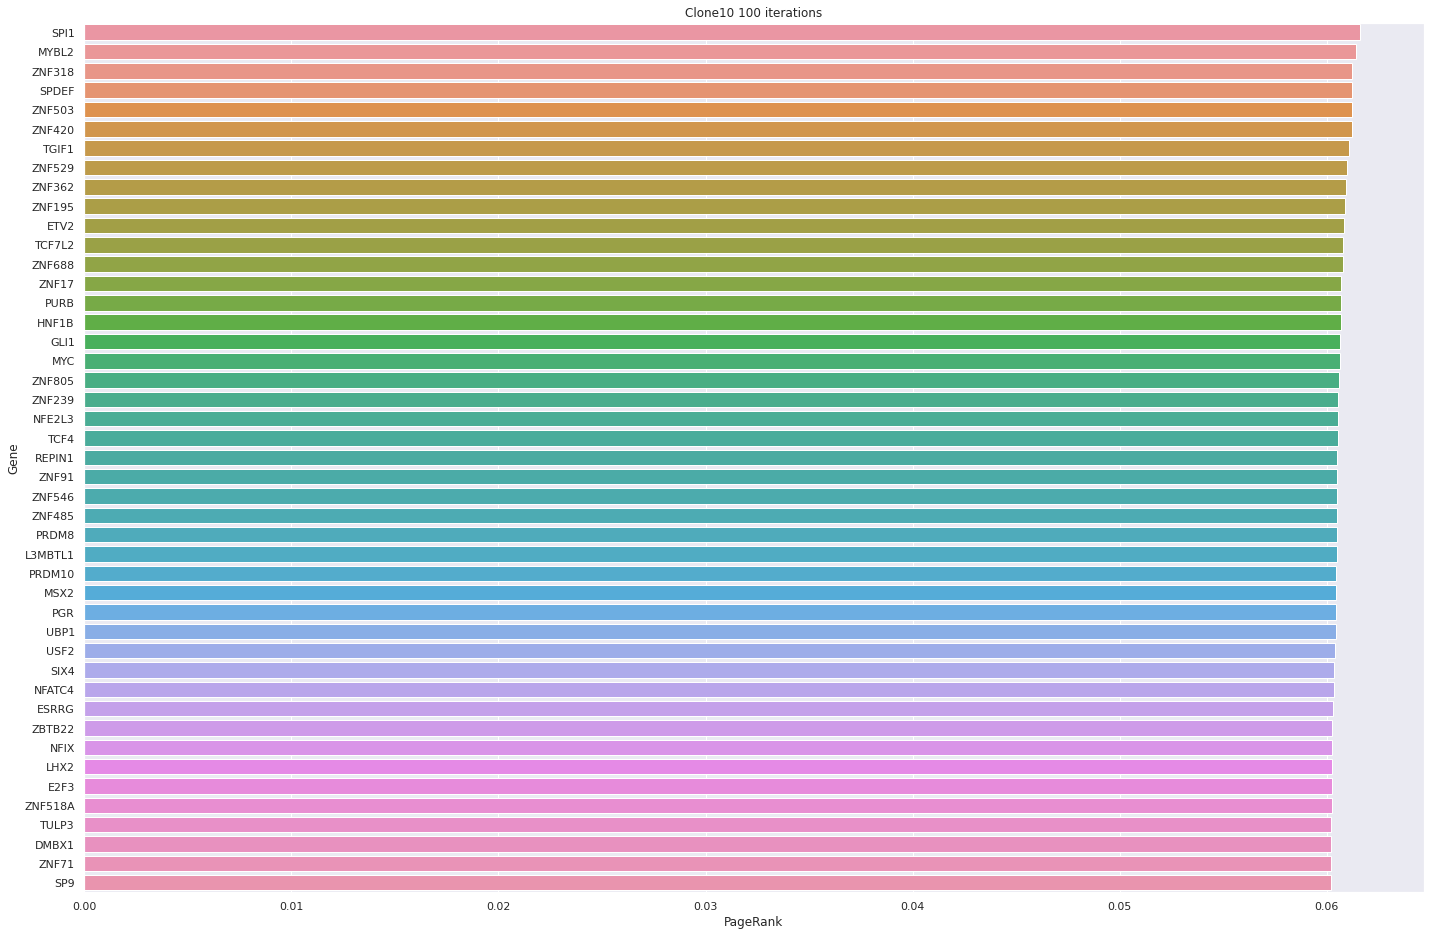

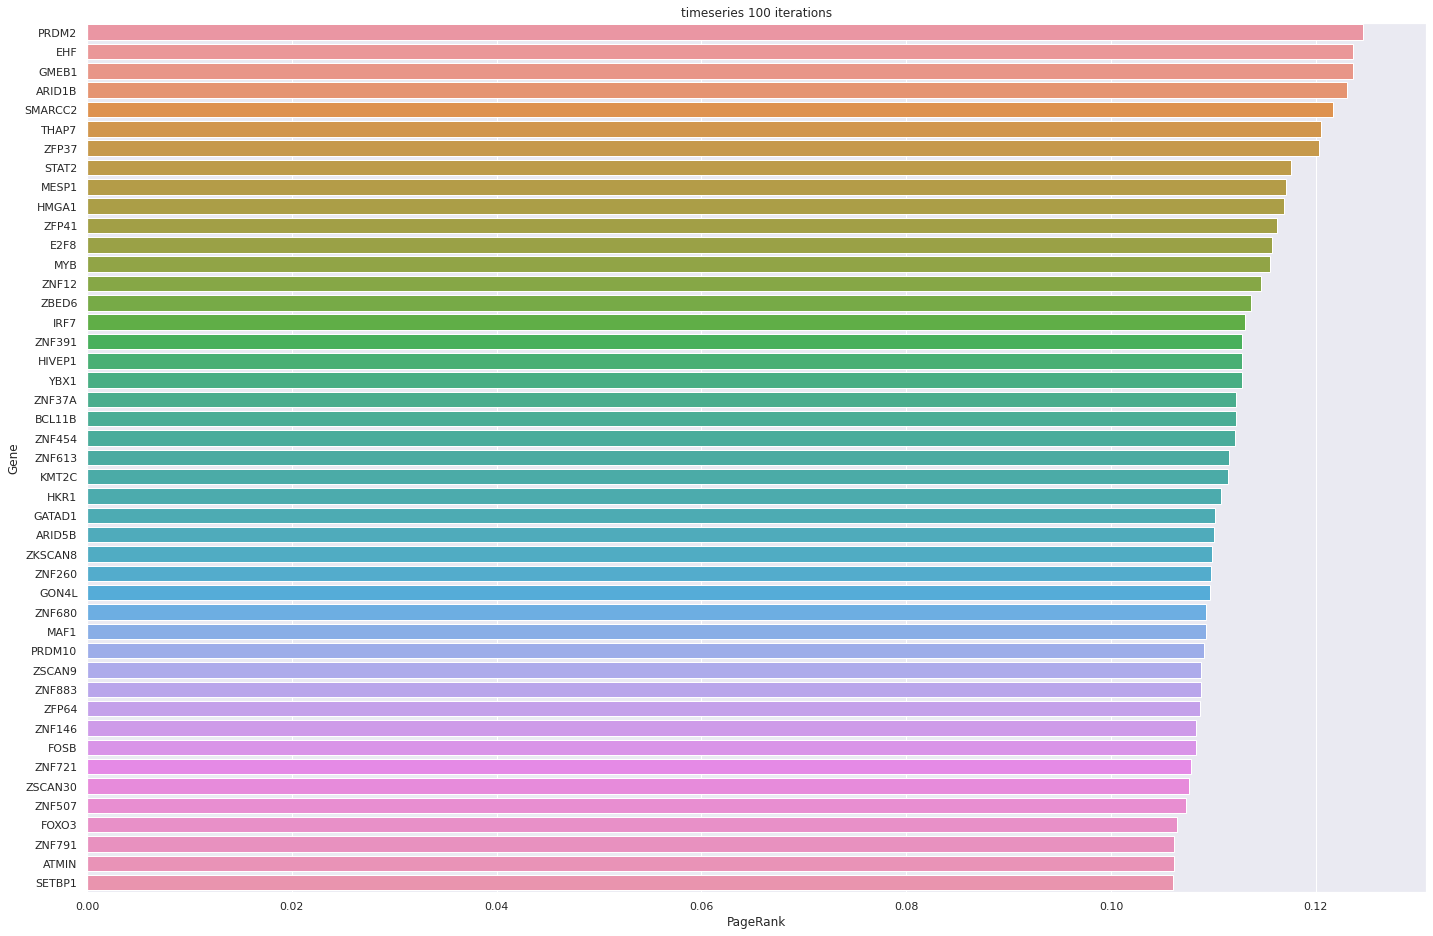

In [3]:
# Visualize aggregate data
wd = '/home/users/jvs15/MachineLearningProstate/STAMPScreen/grn_centrality'
names = ['Clone03.csv', 'Clone04.csv', 'Clone07.csv', 'Clone10.csv', 'timeseries.csv']
prdf_tot = [pd.read_csv(f'{wd}/aggregate_tfs_LNCaP_{i}') for i in names]

for i in range(len(prdf_tot)):
        sns.set(rc={'figure.figsize':(24,16)})
        sns.barplot(
            data=prdf_tot[i].sort_values('PageRank', ascending=False).head(45), 
            x='PageRank', 
            y='Gene'
        ).set(title=f'{names[i][0:len(names[i])-4]} 100 iterations')
        data=prdf_tot[i].sort_values('PageRank', ascending=False)
        #Save ranked TFs
        data.to_csv(f'aggregate_{names[i][0:len(names[i])-4]}_pageranked_tfs.csv')
        plt.show()

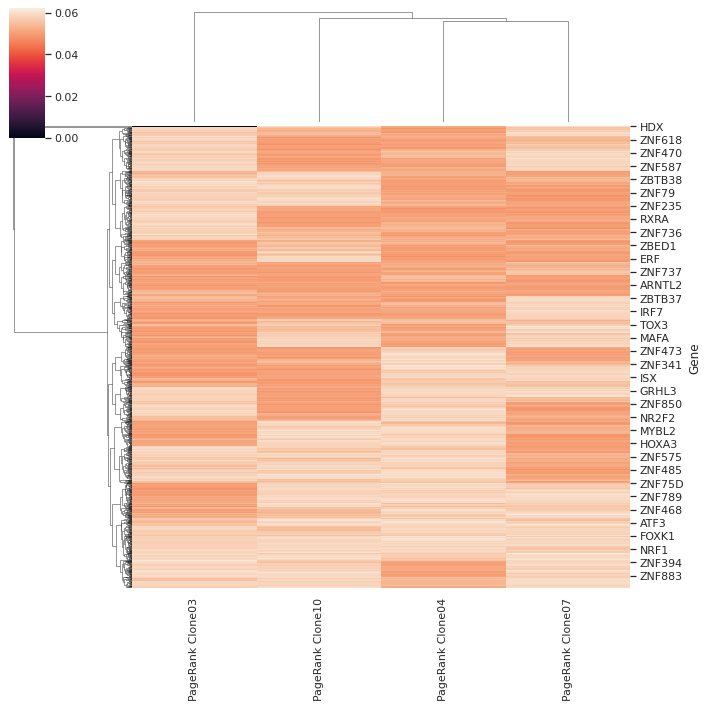

In [35]:
# Make a heatmap of aggregate pageranks

wd = '/home/users/jvs15/MachineLearningProstate/STAMPScreen/grn_centrality'
names = ['Clone03.csv', 'Clone04.csv', 'Clone07.csv', 'Clone10.csv', 'timeseries.csv']
prdf_tot = [pd.read_csv(f'{wd}/aggregate_tfs_LNCaP_{i}') for i in names]

newdf = pd.DataFrame()

for i in range(len(prdf_tot)):
    prdf_tot[i] = prdf_tot[i].drop('Unnamed: 0', axis=1)
    prdf_tot[i].set_index('Gene')
    prdf_tot[i].rename(columns={'PageRank':f'PageRank {names[i][0:len(names[i])-4]}'}, inplace=True)
    prdf_tot[i] = prdf_tot[i].set_index('Gene')
    if newdf.empty:
        newdf = prdf_tot[i]
    else:
        a = newdf
        newdf = pd.concat([a, prdf_tot[i]], axis=1)

newdf = newdf.fillna(0)
newdf = newdf.drop(columns=['PageRank timeseries'])

g = sns.clustermap(newdf)